## Save a datacube to your team storage
### A DeepESDL example notebook 

This notebook demonstrates how save a generated datacube to your team storage. In the example the CCI data store is used, for details concerning the CCI store are given in example notebook 03_Generate_CCI_cubes.ipynb

Please, also refer to the [DeepESDL documentation](https://earthsystemdatalab.net/guide/jupyterlab) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2025

-----------------

**This notebook runs with the python environment `users-deepesdl-xcube-1.9.1`, please checkout the documentation for [help on changing the environment](https://earthsystemdatalab.net/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kernel).**


In [1]:
# mandatory imports
import datetime
import os

import matplotlib.pyplot as plt
import shapely.geometry
from xcube.core.store import new_data_store

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16, 8

Provide mandatory parameters to instantiate the store class:

In [3]:
store = new_data_store("ccizarr")

Let's open an example dataset:

In [4]:
def open_zarrstore(filename, time_range, variables, bbox):
    min_lat, min_lon, max_lat, max_lon = bbox
    ds = store.open_data(filename)

    subset = ds.sel(
        lat=slice(min_lat, max_lat),
        lon=slice(min_lon, max_lon),
        time=slice(time_range[0], time_range[1]),
    )
    subset = subset[variables]

    return subset


dataset = open_zarrstore(
    "ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr",
    time_range=[datetime.datetime(2016, 10, 1), datetime.datetime(2016, 10, 2)],
    variables=["lst"],
    bbox=[35, -10, 70, 30],
)

/home/conda/users/635b18b7-1749540690-47-deepesdl-xcube-1.9.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:174: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dataset = xr.open_zarr(


In [5]:
dataset

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 2, lat: 3500, lon: 4000)
Coordinates:
  * lat      (lat) float32 14kB 35.01 35.01 35.02 35.03 ... 69.97 69.98 69.99
  * lon      (lon) float32 16kB -9.995 -9.985 -9.975 ... 29.98 29.98 29.99
  * time     (time) datetime64[ns] 16B 2016-10-01 2016-10-02
Data variables:
    lst      (time, lat, lon) float64 224MB dask.array<chunksize=(1, 1500, 1000), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3C global land surf...
    time_coverage_duration:     PT04M59S
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature data at ...

Plot one time stamp of the dataset for a analysed_sst in order to take a brief look at the dataset:  

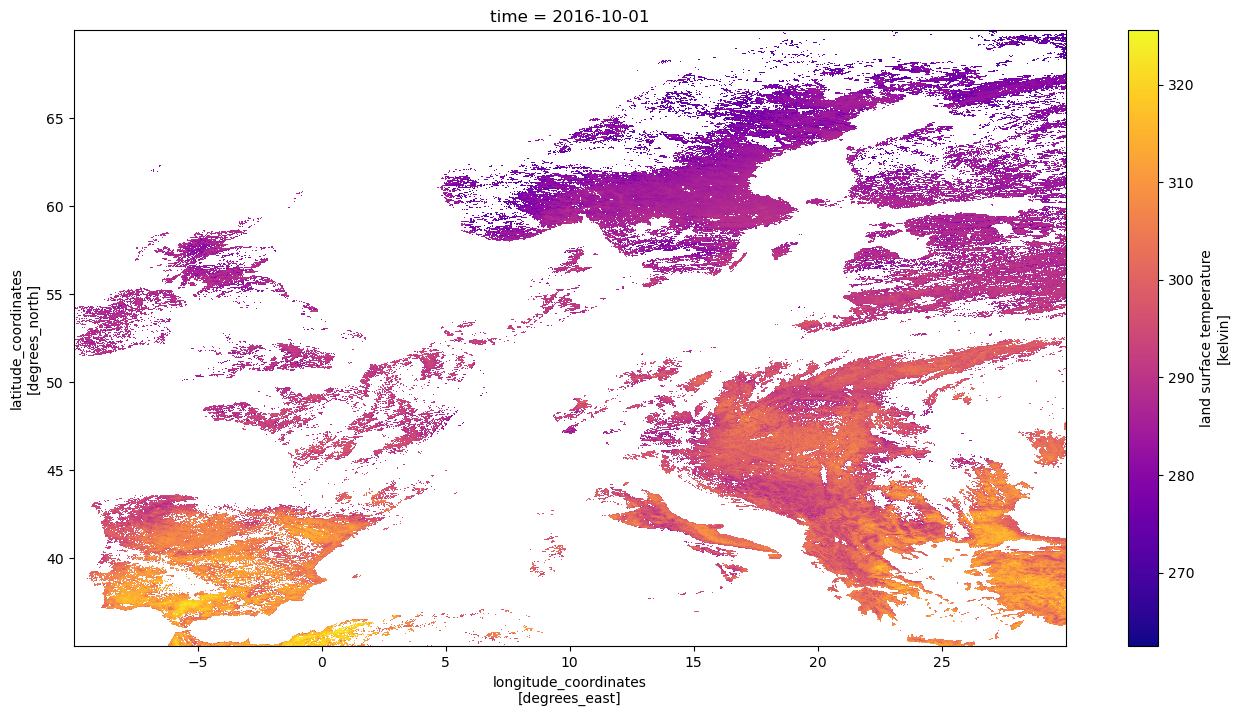

In [6]:
dataset.lst.isel(time=0).plot.imshow(cmap="plasma")

To store the cube in your teams user space, please first retrieve the details from your environment variables as the following:

In [7]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

You need to instantiate a s3 datastore pointing to the team bucket:

In [8]:
team_store = new_data_store(
    "s3",
    root=S3_USER_STORAGE_BUCKET,
    storage_options=dict(
        anon=False, key=S3_USER_STORAGE_KEY, secret=S3_USER_STORAGE_SECRET
    ),
)

If you have stored no data to your user space, the returned list will be empty:

In [19]:
list(team_store.get_data_ids())

['analysed_lst_RC.levels',
 'analysed_lst_bozza.levels',
 'analysed_lst_test_Davide.levels']

Save in levels format to generate data pyramid for efficient visualisation

In [10]:
team_store.write_data(
    dataset, "analysed_lst_AB.levels", replace=True, use_saved_levels=True
)

'analysed_lst_AB.levels'

If you list the content of you datastore again, you will now see the newly written dataset in the list:

In [11]:
list(team_store.get_data_ids())

['analysed_lst.levels', 'analysed_lst_AB.levels']

Open data from your team storage: 

In [12]:
ml_dataset = team_store.open_data("analysed_lst.levels")
ml_dataset

Check, how many levels were written:

In [13]:
ml_dataset.num_levels

2

Print metadata details for each multilevel dataset

In [14]:
for level in range(ml_dataset.num_levels):
    dataset_i = ml_dataset.get_dataset(level)
    display(dataset_i)

<xarray.Dataset> Size: 224MB
Dimensions:  (lat: 3500, lon: 4000, time: 2)
Coordinates:
  * lat      (lat) float32 14kB 35.01 35.01 35.02 35.03 ... 69.97 69.98 69.99
  * lon      (lon) float32 16kB -9.995 -9.985 -9.975 ... 29.98 29.98 29.99
  * time     (time) datetime64[ns] 16B 2016-10-01 2016-10-02
Data variables:
    lst      (time, lat, lon) float64 224MB dask.array<chunksize=(1, 2000, 2000), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3C global land surf...
    time_coverage_duration:     PT04M59S
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature data at ...

<xarray.Dataset> Size: 56MB
Dimensions:  (lat: 1750, lon: 2000, time: 2)
Coordinates:
  * lat      (lat) float32 7kB 35.01 35.02 35.05 35.06 ... 69.94 69.96 69.98
  * lon      (lon) float32 8kB -9.995 -9.975 -9.955 -9.935 ... 29.95 29.96 29.98
  * time     (time) datetime64[ns] 16B 2016-10-01 2016-10-02
Data variables:
    lst      (time, lat, lon) float64 56MB dask.array<chunksize=(1, 1750, 2000), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3C global land surf...
    time_coverage_duration:     PT04M59S
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature data at ...

To work with a certain level:

In [15]:
dataset_1 = ml_dataset.get_dataset(1)

In [16]:
dataset_1

<xarray.Dataset> Size: 56MB
Dimensions:  (lat: 1750, lon: 2000, time: 2)
Coordinates:
  * lat      (lat) float32 7kB 35.01 35.02 35.05 35.06 ... 69.94 69.96 69.98
  * lon      (lon) float32 8kB -9.995 -9.975 -9.955 -9.935 ... 29.95 29.96 29.98
  * time     (time) datetime64[ns] 16B 2016-10-01 2016-10-02
Data variables:
    lst      (time, lat, lon) float64 56MB dask.array<chunksize=(1, 1750, 2000), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3C global land surf...
    time_coverage_duration:     PT04M59S
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature data at ...

To delete a dataset from your team user space:

In [17]:
team_store.delete_data("analysed_lst_AB.levels")

In [18]:
list(team_store.get_data_ids())

['analysed_lst_RC.levels',
 'analysed_lst_bozza.levels',
 'analysed_lst_test_Davide.levels']